## Class 5 - Bagging and Boosting

### Recap of lecture and introductory remarks
In yesterday's lecture, we introduced bagging and boosting as two techniques to reduce variance and reduce variance of decision trees. Bagging and boosting are not specific to decision trees, but we will see them in action with this kind of model.

We used bagging to train a set of small decision trees (weak learners) on subsets of the training data, whose individual predictions we aggregate to make a single prediction. The resulting model is an _ensemble_ model. We have seen that `Random Forests` are popular learning algorithms that combine bagging with random sampling of features, to induce diversity in decision trees and further regularization.

On the other hand, boosting consists in training a sequence of decision trees which iteratively reduce the error of the previous decision tree because they are fitted on the residuals or on the gradients of the previous tree. We have focused specifically on `gradient boosting` and indicated `XGBoost` as a particularly powerful implementation of boosting + bagging.

Today, we will go back to the bike data, and fit `RandomForest` and `XGBoost` models, comparing their performances to those of models fitted previously. We will implement Random Forests using `scikit-learn`, and XGBoost using the XGBoost package: https://xgboost.readthedocs.io/en/stable/ 

**Note**: As last week, under `nbs/class_05` you will find a notebook called `example.ipynb`, where I provide an example of how to run today's exercise on sample data.

### Operational remarks
Two suggestions on how to go about this, based on where you are at regarding exercises from previous weeks.

If you have done exercises from class 2 and 3, you will have one/two notebooks with baseline, linear, KNN, and linear regularized models, as well as records of performances (which will be handy to compare performances of our new methods). In this case, my suggestion would be to work on a new notebook where you only fit the new models, and load the performance of the old models for comparison.

If you have not done exercises from previous classes, you have two options:
- Work on a new notebook and "manually" compare the performance of your new models to plots from previous weeks;
- Work on a new notebook and also implement a couple of models from previous weeks for comparison.

### Today's exercise
Work in groups on the following tasks

1. Fit a `Random Forest` model to the data (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor), using cross-validation to define the best possible range of parameters
    - There are a number of parameters that should be passed to the estimator. Carefully read the documentation, and identify a few hyperparameters you might want to manipulate
    - Define a series of possible values for these hyperparameters, and store this information into a Python dictionary. For each hyperparameter, the dictionary should include the name of the hyperparameters (as a string) as `key`, and a list including a range of possible values as `value`
    - Pass your estimator and the parameter grid to `GridSearchCV`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html and fit this object to your training set. If you have defined *a lot* of possible values, you can consider using `RandomizedSearchCV`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html. **Note**: you need to pass something appropriate as the value of the `scoring` argument
    - Try to answer the following questions:
        - What is `GridSearchCV` doing?
        - What is the difference between `RandomizedSearchCV` and `GridSearchCV`?
        - **Bonus question**: Given that we do have a validation set, could we do model selection without using cross-validation? Which parameter in `GridSearchCV` or `RandomizedSearchCV` would you have to change, and how, to do so?
    - Find out which hyperparameters gave the best result
        - **Hint**: look at the `.best_estimator_` attribute on a fitted `GridSearchCV`/`RandomizedSearchCV` and `.get_params()`
    - Compute the performance of this model on the training, validation, and test set
    - Compute and plot feature importances for the resulting model. You can look at the `.feature_importances_` attribute of the best estimator.
        - **Bonus question**: which method is used by default to compute feature importances? Is any other method available in `sklearn`?

2. Do the exact same things as 1., this time using `XGBRegressor` (https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)
    - Note: you will have to install `xgboost` (https://xgboost.readthedocs.io/en/stable/install.html) to run this
    - You will have to define an appropriate `scoring` parameter
    - Parameters for grid/randomized search will be slightly different: look at the documentation for XGBRegressor, and make informed choices based on what we discussed in class

3. Plot the performance of the best Random Forest models and the best XGBoost models, against models you fitted previously
    - Which models perform best?
    - How does the performance profile of RandomForest compare to XGBoost? Why?

4. Compare feature importances across `RandomForest` and `XGBoost`: do they look similar/different?

5. Overall reflection on modeling process
    - Reflect back on your choices for previous models: should you have transformed any of the features before fitting Linear Regression, KNN, or regularized models?
    - Can you think of ways in which our predictive problem can be made more interesting from a business perspective?
    - Which aspect of the data are we *not* modeling, that we could/should model?


### Extra tasks
- Estimate a `DecisionTreeRegressor` with cross-validation, using the same logic we applied above: how does the performance of the resulting model compare to `RandomForestRegressor` and `XGBoost` regressor?
- Go back to your fitted `GridSearchCV` or `RandomizedSearchCV`, and inspect their attributes. Can you plot performance against values of each of the parameters you are fitting? Is there any systematic pattern?
- Reflect on hyperparameters passed to `GridSearchCV` or `RandomizedSearchCV`: how do you expect that individual manipulations of these parameters would affect the bias/variance profile of your models?



In [157]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


First, let's load our dataset. Here, I will reload a dataset to make the example complete, but you can import your training, development and test sets from the last exercise.

In [158]:
train = pd.read_csv(f'logs/example-data/train.csv', index_col=0)
val = pd.read_csv(f'logs/example-data/val.csv', index_col=0)
test = pd.read_csv(f'logs/example-data/test.csv', index_col=0)

In [159]:
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

Let's also load our performances from last week

In [160]:
perf_df = pd.read_csv('logs/performances.csv', index_col=0)
performances = perf_df.to_dict(orient='records')

### Model evaluation
As in previous notebooks, let's define some useful functions for model evaluation.
To add some flavor to it, since we have to apply the same function to all data subsets multiple times, let's do something very Pythonic.
We define a decorator (next chunk), which takes a function as an input, and it runs it several times, on each of our data splits.
Then, we define a function to pass to this decorator (our `evaluate` function, which is very, very similar to the one we defined in previous notebooks).

In [161]:
def run_on_splits(func):
    def _run_loop(*args, **kwargs):
        for x,y,nsplit in zip([X_train, X_val, X_test],
                              [y_train, y_val, y_test],
                              ['train', 'val', 'test']):
            func(*args, X=x, y=y, nsplit=nsplit, **kwargs)
    return _run_loop

In [162]:
@run_on_splits
def evaluate(model, X, y, nsplit, model_name):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): an identifier for the model
    '''
    preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

### Random Forest
In the following, we fit a Random Forest model, varying a range of parameters and estimating the best combination using CV.

In [163]:
rfreg = RandomForestRegressor(random_state=42) # first, we instantiate the estimator

This is a grid of parameters we will iterate on

In [164]:
param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.3, 0.6, 0.9], # can you guess what this is, without looking at the documentation?
    'ccp_alpha': [0.01, 0.1, 1.0]
}

In the following, we will run cross-validation

In [165]:
cv_rfr = RandomizedSearchCV(estimator=rfreg, 
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error', # this is "neg" because CV wants a metric to maximize
                            n_iter=200, # this should more likely be something like 100
                            cv=5)
cv_rfr.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=200,
                   param_distributions={'ccp_alpha': [0.01, 0.1, 1.0],
                                        'max_depth': [2, 3, 5, 10],
                                        'max_features': [0.3, 0.6, 0.9],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 100, 200,
                                                         500]},
                   scoring='neg_mean_squared_error')

Let's check the best parameters

In [166]:
cv_rfr.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.1,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 0.3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Let's compute and store performances for the best model

In [167]:
evaluate(model=cv_rfr.best_estimator_, model_name=f'random-forest')

and finally, let's look at feature importances

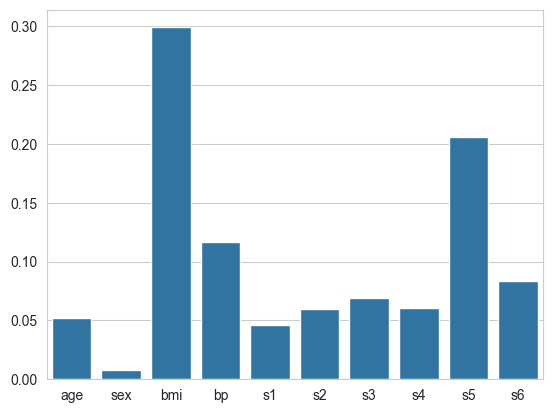

In [168]:
# from sklearn.inspection import permutation_importance
#importances = permutation_importance(cv_rfr.best_estimator_, X_train, y_train,
#                                     n_repeats=30,
#                                     random_state=0,
#                                     scoring='neg_mean_squared_error')['importances_mean']
importances = cv_rfr.best_estimator_.feature_importances_
# the above computes the (normalized) total reduction of the criterion brought by that feature.
sns.barplot(x=train.columns.tolist()[:-1], y=importances, color=sns.color_palette()[0])
plt.show()

### XGBoost
Now let's do the same thing, this time with XGBoost. First, let's define some basic parameters we iterate on.

In [169]:
xgbreg = XGBRegressor(random_state=42)

param_grid = { 
    'n_estimators': [10, 20, 100, 200, 500],
    'max_depth' : [2, 3, 5, 10],
    'objective': ['reg:squarederror'],
    'colsample_bytree': [0.3, 0.6, 0.9],
    'learning_rate': [2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
}

In [170]:
cv_xgb = RandomizedSearchCV(estimator=xgbreg, 
                            param_distributions=param_grid,
                            scoring='neg_mean_squared_error',
                            n_iter=200, # this should be at least 100
                            cv=5)
cv_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=200,
                   param_distributions={'colsample_bytree': [0.3, 0.6, 0.9],
                                        'learning_rate': [2e-05, 0.0002, 0.002,
                                                          0.02, 0.2],
                                        'max_depth': [2, 3, 5, 10],
                                        'n_estimators': [10, 20, 100, 200, 500],
                                        'objective': ['reg:squarederror']},
                   scoring='neg_mean_squared_error')

In [171]:
cv_xgb.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__objective': 'reg:squarederror',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__multi_strategy': None,
 'estimato

In [172]:
evaluate(model=cv_xgb.best_estimator_, model_name=f'xgboost')

let's look at feature importances

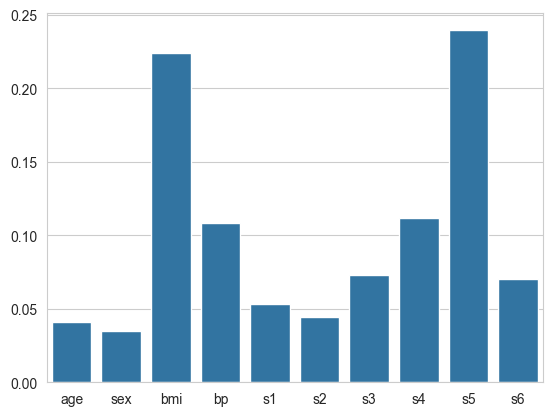

In [173]:
importances = cv_xgb.best_estimator_.feature_importances_
sns.barplot(x=train.columns.tolist()[:-1], y=importances, color=sns.color_palette()[0])
plt.show()

Feature importances for the best model are very different (apart from the dominance of BMI). While RandomForest uses demographics a lot, XGBoost tends to use specific biometric values to make predictions.

### Plot performances

In [175]:
perf_df = pd.DataFrame(performances)

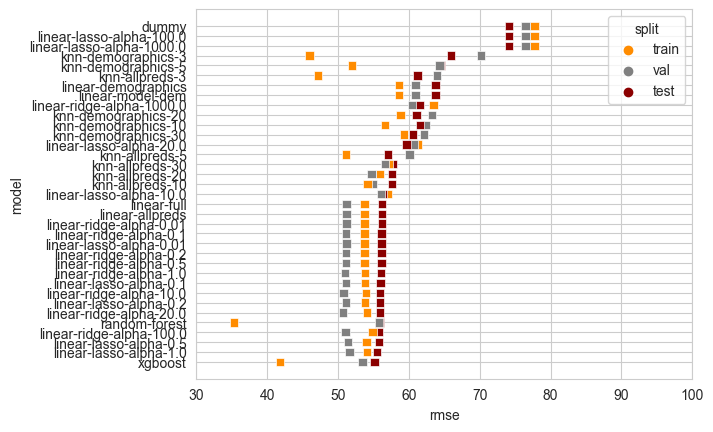

In [176]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.xlim(30,100)
plt.show()